# Question 1

Derive the restricted Boltzmann machine algorithm that you will implement, and explain your derivation. Implement the training and inference algorithms for RBM. Train RBMs with 20, 100 and 500 hidden nodes to generate MNIST images using the training data set. Generate MNIST images from the ones in the testing data set that have 20%, 50% and 80% pixels missing/removed. You are free to choose whether you want to use binary nodes or floating point nodes, but the derivation has to match the implementation.

${\text{Markov Structure of RBM}}$

${\text{p(h|x) = }\prod_{j}\text{p(}\text{h}_{j}\text{|x)}}$

${\text{p(}\text{h}_{j}\text{ =1 |x) = }\frac{1}{\text{1 + exp(-(}\text{b}_j\text{ + }\text{W}_j\text{x))}}}$

${\text{= sigm(}\text{b}_j\text{ + }\text{W}_j\text{x))}}$

${\text{p(x|h) = }\prod_{k}\text{p(}\text{x}_{k}\text{|h)}}$

${\text{p(}\text{x}_{k}\text{ =1 |h) = }\frac{1}{\text{1 + exp(-(}\text{c}_k\text{ + }\text{h}^T\text{W.}_k))}}$
${\text{= sigm(}\text{c}_k\text{ +h}^T\text{ W.}_k)}$

${\text{Training Algorithm of RBM}}$

${\text{Given training data }\text{x}^1\text{,...,}\text{x}^T}$

${\text{p(x) = }\sum_{h\in(0,1)^H}\text{p(x,h)= }\sum_{h\in(0,1)^H}\text{exp(-E(x,h)) / Z}}$

${\text{= exp(}\text{c}^T\text{ + }\sum_{j=1}^H\text{ log(1 + exp(}\text{b}_j\text{ + }\text{W}_j\text{.x))) /Z}\text { , where }\text{ log(1 + exp(}\text{b}_j\text{ + }\text{W}_j\text{.x)) is soft-plus}}$

${\text{= exp (- F(x) ) / Z ,where F(x) is Free energy}}$

### RBM 500 Nodes

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

C:\Users\sravi\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import random
import gzip, struct

class DataSet:
    batch_index = 0
    
    def __init__(self, data_dir, batch_size = None, one_hot = False, seed = 0):
        self.data_dir = data_dir
        X, Y = self.read()
        shape = X.shape
        X = X.reshape([shape[0], shape[1] * shape[2]])
        self.X = X.astype(np.float)/255
        self.size = self.X.shape[0]
        if batch_size == None:
            self.batch_size = self.size
        else:
            self.batch_size = batch_size
        # abandom last few samples
        self.batch_num = int(self.size / self.batch_size)
        # shuffle samples
        np.random.seed(seed)
        np.random.shuffle(self.X)
        np.random.seed(seed)
        np.random.shuffle(Y)
        self.one_hot = one_hot
        if one_hot:
            y_vec = np.zeros((len(Y), 10), dtype=np.float)
            for i, label in enumerate(Y):
                y_vec[i, Y[i]] = 1.0
            self.Y = y_vec
        else:
            self.Y = Y
    
    def read(self):
        with gzip.open(self.data_dir['Y']) as flbl:
            magic, num = struct.unpack(">II", flbl.read(8))
            label = np.fromstring(flbl.read(), dtype=np.int8)
        with gzip.open(self.data_dir['X'], 'rb') as fimg:
            magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
            image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
        return image,label
    
    def next_batch(self):
        start = self.batch_index * self.batch_size
        end = (self.batch_index + 1) * self.batch_size
        self.batch_index = (self.batch_index + 1) % self.batch_num
        if self.one_hot:
            return self.X[start:end, :], self.Y[start:end, :]
        else:
            return self.X[start:end, :], self.Y[start:end]
        
    def sample_batch(self):
        index = random.randrange(self.batch_num)
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        if self.one_hot:
            return self.X[start:end, :], self.Y[start:end, :]
        else:
            return self.X[start:end, :], self.Y[start:end]

In [6]:
def test_DataSet():
    train_dir = {
        'X': 'train-images-idx3-ubyte.gz', 
        'Y': 'train-labels-idx1-ubyte.gz'
    }
    test_dir = {
        'X': 't10k-images-idx3-ubyte.gz', 
        'Y': 't10k-labels-idx1-ubyte.gz'
    }
    mnist = DataSet(test_dir, 2)
    print('batch index: %d' % mnist.batch_index)
    X, Y = mnist.next_batch()
    print('batch index: %d' % mnist.batch_index)
    print('X:')
    print(X)
    print('Y:')
    print(Y)

In [7]:
test_DataSet()

C:\Users\sravi\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
C:\Users\sravi\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


batch index: 0
batch index: 1
X:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Y:
[8 7]


In [8]:
train_dir = {
    'X': 'train-images-idx3-ubyte.gz', 
    'Y': 'train-labels-idx1-ubyte.gz'
}
test_dir = {
    'X': './mnist/t10k-images-idx3-ubyte.gz', 
    'Y': './mnist/t10k-labels-idx1-ubyte.gz'
}

In [9]:
def weight(shape, name='weights'):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name=name)

In [10]:
def bias(shape, name='biases'):
    return tf.Variable(tf.constant(0.1, shape=shape), name=name)

In [11]:
class RBM:
    i = 0 # fliping index for computing pseudo likelihood
    
    def __init__(self, n_visible=784, n_hidden=500, k=30, momentum=False):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.k = k
        
        self.lr = tf.placeholder(tf.float32)
        if momentum:
            self.momentum = tf.placeholder(tf.float32)
        else:
            self.momentum = 0.0
        self.w = weight([n_visible, n_hidden], 'w')
        self.hb = bias([n_hidden], 'hb')
        self.vb = bias([n_visible], 'vb')
        
        self.w_v = tf.Variable(tf.zeros([n_visible, n_hidden]), dtype=tf.float32)
        self.hb_v = tf.Variable(tf.zeros([n_hidden]), dtype=tf.float32)
        self.vb_v = tf.Variable(tf.zeros([n_visible]), dtype=tf.float32)
        
    def propup(self, visible):
        pre_sigmoid_activation = tf.matmul(visible, self.w) + self.hb
        return tf.nn.sigmoid(pre_sigmoid_activation)
    
    def propdown(self, hidden):
        pre_sigmoid_activation = tf.matmul(hidden, tf.transpose(self.w)) + self.vb
        return tf.nn.sigmoid(pre_sigmoid_activation)
    
    def sample_h_given_v(self, v_sample):
        h_props = self.propup(v_sample)
        h_sample = tf.nn.relu(tf.sign(h_props - tf.random_uniform(tf.shape(h_props))))
        return h_sample
    
    def sample_v_given_h(self, h_sample):
        v_props = self.propdown(h_sample)
        v_sample = tf.nn.relu(tf.sign(v_props - tf.random_uniform(tf.shape(v_props))))
        return v_sample
    
    def CD_k(self, visibles):       
        # k steps gibbs sampling
        v_samples = visibles
        h_samples = self.sample_h_given_v(v_samples)
        for i in range(self.k):
            v_samples = self.sample_v_given_h(h_samples)
            h_samples = self.sample_h_given_v(v_samples)
        
        h0_props = self.propup(visibles)
        w_positive_grad = tf.matmul(tf.transpose(visibles), h0_props)
        w_negative_grad = tf.matmul(tf.transpose(v_samples), h_samples)
        w_grad = (w_positive_grad - w_negative_grad) / tf.to_float(tf.shape(visibles)[0])
        hb_grad = tf.reduce_mean(h0_props - h_samples, 0)
        vb_grad = tf.reduce_mean(visibles - v_samples, 0)
        return w_grad, hb_grad, vb_grad
    
    def learn(self, visibles):
        w_grad, hb_grad, vb_grad = self.CD_k(visibles)
        # compute new velocities
        new_w_v = self.momentum * self.w_v + self.lr * w_grad
        new_hb_v = self.momentum * self.hb_v + self.lr * hb_grad
        new_vb_v = self.momentum * self.vb_v + self.lr * vb_grad
        # update parameters
        update_w = tf.assign(self.w, self.w + new_w_v)
        update_hb = tf.assign(self.hb, self.hb + new_hb_v)
        update_vb = tf.assign(self.vb, self.vb + new_vb_v)
        # update velocities
        update_w_v = tf.assign(self.w_v, new_w_v)
        update_hb_v = tf.assign(self.hb_v, new_hb_v)
        update_vb_v = tf.assign(self.vb_v, new_vb_v)
        
        return [update_w, update_hb, update_vb, update_w_v, update_hb_v, update_vb_v]
        
    def sampler(self, visibles, steps=5000):
        v_samples = visibles
        for step in range(steps):
            v_samples = self.sample_v_given_h(self.sample_h_given_v(v_samples))
        return v_samples
    
    def free_energy(self, visibles):
        first_term = tf.matmul(visibles, tf.reshape(self.vb, [tf.shape(self.vb)[0], 1]))
        second_term = tf.reduce_sum(tf.log(1 + tf.exp(self.hb + tf.matmul(visibles, self.w))), axis=1)
        return - first_term - second_term
    
    def pseudo_likelihood(self, visibles):
        x = tf.round(visibles)
        x_fe = self.free_energy(x)
        split0, split1, split2 = tf.split(x, [self.i, 1, tf.shape(x)[1] - self.i - 1], 1)
        xi = tf.concat([split0, 1 - split1, split2], 1)
        self.i = (self.i + 1) % self.n_visible
        xi_fe = self.free_energy(xi)
        return tf.reduce_mean(self.n_visible * tf.log(tf.nn.sigmoid(xi_fe - x_fe)), axis=0)

In [12]:
import scipy.misc

def save_images(images, size, path):
    
    """
    Save the samples images
    The best size number is
            int(max(sqrt(image.shape[0]),sqrt(image.shape[1]))) + 1
    example:
        The batch_size is 64, then the size is recommended [8, 8]
        The batch_size is 32, then the size is recommended [6, 6]
    """
    
    img = (images + 1.0) / 2.0
    h, w = img.shape[1], img.shape[2]
    
    merge_img = np.zeros((h * size[0], w * size[1]))
    
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        merge_img[j*h:j*h+h, i*w:i*w+w] = image
        
    return scipy.misc.imsave(path, merge_img)

In [13]:
def train(train_data, epoches):
    logs_dir = './PRAssignment5/logs'
    samples_dir = './PRAssignment5/samples'
    
    x = tf.placeholder(tf.float32, shape=[None, 784])
    noise_x, _ = train_data.sample_batch()
    # noise_x = tf.random_normal([train_data.batch_size, 784])
    rbm = RBM()
    step = rbm.learn(x)
    sampler = rbm.sampler(x)
    pl = rbm.pseudo_likelihood(x)
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        mean_cost = []
        epoch = 1
        for i in range(epoches * train_data.batch_num):
            # draw samples
            if i % 500 == 0:
                samples = sess.run(sampler, feed_dict = {x: noise_x})
                samples = samples.reshape([train_data.batch_size, 28, 28])
                save_images(samples, [8, 8], os.path.join(samples_dir, 'iteration_%d.png' % i))
                print('Saved samples.')
            batch_x, _ = train_data.next_batch()
            sess.run(step, feed_dict = {x: batch_x, rbm.lr: 0.1})
            cost = sess.run(pl, feed_dict = {x: batch_x})
            mean_cost.append(cost)
            # save model
            if i is not 0 and train_data.batch_index is 0:
                checkpoint_path = os.path.join(logs_dir, 'model.ckpt')
                saver.save(sess, checkpoint_path, global_step = epoch + 1)
                print('Saved Model.')
            # print pseudo likelihood
            if i is not 0 and train_data.batch_index is 0:
                print('Epoch %d Cost %g' % (epoch, np.mean(mean_cost)))
                mean_cost = []
                epoch += 1
        print('Test')
        samples = sess.run(sampler, feed_dict = {x: noise_x})
        samples = samples.reshape([train_data.batch_size, 28, 28])
        save_images(samples, [8, 8], os.path.join(samples_dir, 'test.png'))
        print('Saved samples.')

In [14]:
train_data = DataSet(data_dir=train_dir, batch_size=64, one_hot=True)

C:\Users\sravi\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
C:\Users\sravi\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [15]:
train(train_data, 20)

C:\Users\sravi\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Saved samples.
Saved samples.
Saved Model.
Epoch 1 Cost -1.34346
Saved samples.
Saved samples.
Saved Model.
Epoch 2 Cost -0.317312
Saved samples.
Saved samples.
Saved Model.
Epoch 3 Cost -0.168298
Saved samples.
Saved samples.
Saved Model.
Epoch 4 Cost -0.114781
Saved samples.
Saved samples.
Saved Model.
Epoch 5 Cost -0.0944169
Saved samples.
Saved samples.
Saved Model.
Epoch 6 Cost -0.0750124
Saved samples.
Saved samples.
Saved Model.
Epoch 7 Cost -0.0698007
Saved samples.
Saved Model.
Epoch 8 Cost -0.0643846
Saved samples.
Saved samples.
Saved Model.
Epoch 9 Cost -0.0613495
Saved samples.
Saved samples.
Saved Model.
Epoch 10 Cost -0.0585278
Saved samples.
Saved samples.
Saved Model.
Epoch 11 Cost -0.0504098
Saved samples.
Saved samples.
Saved Model.
Epoch 12 Cost -0.0447847
Saved samples.
Saved samples.


KeyboardInterrupt: 

### RBM for 100 nodes

In [16]:
class RBM:
    i = 0 # fliping index for computing pseudo likelihood
    
    def __init__(self, n_visible=784, n_hidden=100, k=30, momentum=False):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.k = k
        
        self.lr = tf.placeholder(tf.float32)
        if momentum:
            self.momentum = tf.placeholder(tf.float32)
        else:
            self.momentum = 0.0
        self.w = weight([n_visible, n_hidden], 'w')
        self.hb = bias([n_hidden], 'hb')
        self.vb = bias([n_visible], 'vb')
        
        self.w_v = tf.Variable(tf.zeros([n_visible, n_hidden]), dtype=tf.float32)
        self.hb_v = tf.Variable(tf.zeros([n_hidden]), dtype=tf.float32)
        self.vb_v = tf.Variable(tf.zeros([n_visible]), dtype=tf.float32)
        
    def propup(self, visible):
        pre_sigmoid_activation = tf.matmul(visible, self.w) + self.hb
        return tf.nn.sigmoid(pre_sigmoid_activation)
    
    def propdown(self, hidden):
        pre_sigmoid_activation = tf.matmul(hidden, tf.transpose(self.w)) + self.vb
        return tf.nn.sigmoid(pre_sigmoid_activation)
    
    def sample_h_given_v(self, v_sample):
        h_props = self.propup(v_sample)
        h_sample = tf.nn.relu(tf.sign(h_props - tf.random_uniform(tf.shape(h_props))))
        return h_sample
    
    def sample_v_given_h(self, h_sample):
        v_props = self.propdown(h_sample)
        v_sample = tf.nn.relu(tf.sign(v_props - tf.random_uniform(tf.shape(v_props))))
        return v_sample
    
    def CD_k(self, visibles):       
        # k steps gibbs sampling
        v_samples = visibles
        h_samples = self.sample_h_given_v(v_samples)
        for i in range(self.k):
            v_samples = self.sample_v_given_h(h_samples)
            h_samples = self.sample_h_given_v(v_samples)
        
        h0_props = self.propup(visibles)
        w_positive_grad = tf.matmul(tf.transpose(visibles), h0_props)
        w_negative_grad = tf.matmul(tf.transpose(v_samples), h_samples)
        w_grad = (w_positive_grad - w_negative_grad) / tf.to_float(tf.shape(visibles)[0])
        hb_grad = tf.reduce_mean(h0_props - h_samples, 0)
        vb_grad = tf.reduce_mean(visibles - v_samples, 0)
        return w_grad, hb_grad, vb_grad
    
    def learn(self, visibles):
        w_grad, hb_grad, vb_grad = self.CD_k(visibles)
        # compute new velocities
        new_w_v = self.momentum * self.w_v + self.lr * w_grad
        new_hb_v = self.momentum * self.hb_v + self.lr * hb_grad
        new_vb_v = self.momentum * self.vb_v + self.lr * vb_grad
        # update parameters
        update_w = tf.assign(self.w, self.w + new_w_v)
        update_hb = tf.assign(self.hb, self.hb + new_hb_v)
        update_vb = tf.assign(self.vb, self.vb + new_vb_v)
        # update velocities
        update_w_v = tf.assign(self.w_v, new_w_v)
        update_hb_v = tf.assign(self.hb_v, new_hb_v)
        update_vb_v = tf.assign(self.vb_v, new_vb_v)
        
        return [update_w, update_hb, update_vb, update_w_v, update_hb_v, update_vb_v]
        
    def sampler(self, visibles, steps=5000):
        v_samples = visibles
        for step in range(steps):
            v_samples = self.sample_v_given_h(self.sample_h_given_v(v_samples))
        return v_samples
    
    def free_energy(self, visibles):
        first_term = tf.matmul(visibles, tf.reshape(self.vb, [tf.shape(self.vb)[0], 1]))
        second_term = tf.reduce_sum(tf.log(1 + tf.exp(self.hb + tf.matmul(visibles, self.w))), axis=1)
        return - first_term - second_term
    
    def pseudo_likelihood(self, visibles):
        x = tf.round(visibles)
        x_fe = self.free_energy(x)
        split0, split1, split2 = tf.split(x, [self.i, 1, tf.shape(x)[1] - self.i - 1], 1)
        xi = tf.concat([split0, 1 - split1, split2], 1)
        self.i = (self.i + 1) % self.n_visible
        xi_fe = self.free_energy(xi)
        return tf.reduce_mean(self.n_visible * tf.log(tf.nn.sigmoid(xi_fe - x_fe)), axis=0)

In [17]:
import scipy.misc

def save_images(images, size, path):
    
    """
    Save the samples images
    The best size number is
            int(max(sqrt(image.shape[0]),sqrt(image.shape[1]))) + 1
    example:
        The batch_size is 64, then the size is recommended [8, 8]
        The batch_size is 32, then the size is recommended [6, 6]
    """
    
    img = (images + 1.0) / 2.0
    h, w = img.shape[1], img.shape[2]
    
    merge_img = np.zeros((h * size[0], w * size[1]))
    
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        merge_img[j*h:j*h+h, i*w:i*w+w] = image
        
    return scipy.misc.imsave(path, merge_img)

In [18]:
def train(train_data, epoches):
    logs_dir = './PRAssignment5/logs'
    samples_dir = './PRAssignment5/samples'
    
    x = tf.placeholder(tf.float32, shape=[None, 784])
    noise_x, _ = train_data.sample_batch()
    # noise_x = tf.random_normal([train_data.batch_size, 784])
    rbm = RBM()
    step = rbm.learn(x)
    sampler = rbm.sampler(x)
    pl = rbm.pseudo_likelihood(x)
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        mean_cost = []
        epoch = 1
        for i in range(epoches * train_data.batch_num):
            # draw samples
            if i % 500 == 0:
                samples = sess.run(sampler, feed_dict = {x: noise_x})
                samples = samples.reshape([train_data.batch_size, 28, 28])
                save_images(samples, [8, 8], os.path.join(samples_dir, 'iteration_%d.png' % i))
                print('Saved samples.')
            batch_x, _ = train_data.next_batch()
            sess.run(step, feed_dict = {x: batch_x, rbm.lr: 0.1})
            cost = sess.run(pl, feed_dict = {x: batch_x})
            mean_cost.append(cost)
            # save model
            if i is not 0 and train_data.batch_index is 0:
                checkpoint_path = os.path.join(logs_dir, 'model.ckpt')
                saver.save(sess, checkpoint_path, global_step = epoch + 1)
                print('Saved Model.')
            # print pseudo likelihood
            if i is not 0 and train_data.batch_index is 0:
                print('Epoch %d Cost %g' % (epoch, np.mean(mean_cost)))
                mean_cost = []
                epoch += 1
        print('Test')
        samples = sess.run(sampler, feed_dict = {x: noise_x})
        samples = samples.reshape([train_data.batch_size, 28, 28])
        save_images(samples, [8, 8], os.path.join(samples_dir, 'test.png'))
        print('Saved samples.')

In [19]:
train_data = DataSet(data_dir=train_dir, batch_size=64, one_hot=True)

C:\Users\sravi\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
C:\Users\sravi\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [20]:
train(train_data, 20)

C:\Users\sravi\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Saved samples.
Saved samples.
Saved Model.
Epoch 1 Cost -3.06169
Saved samples.
Saved samples.
Saved Model.
Epoch 2 Cost -0.492076
Saved samples.
Saved samples.
Saved Model.
Epoch 3 Cost -0.255986
Saved samples.
Saved samples.
Saved Model.
Epoch 4 Cost -0.158695
Saved samples.
Saved samples.
Saved Model.
Epoch 5 Cost -0.112045
Saved samples.
Saved samples.
Saved Model.
Epoch 6 Cost -0.0870367
Saved samples.
Saved samples.
Saved Model.
Epoch 7 Cost -0.0706197
Saved samples.
Saved Model.
Epoch 8 Cost -0.0617849
Saved samples.
Saved samples.
Saved Model.
Epoch 9 Cost -0.0569894
Saved samples.


KeyboardInterrupt: 

### RBM for 20 nodes

In [23]:
class RBM:
    i = 0 # fliping index for computing pseudo likelihood
    
    def __init__(self, n_visible=784, n_hidden=20, k=30, momentum=False):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.k = k
        
        self.lr = tf.placeholder(tf.float32)
        if momentum:
            self.momentum = tf.placeholder(tf.float32)
        else:
            self.momentum = 0.0
        self.w = weight([n_visible, n_hidden], 'w')
        self.hb = bias([n_hidden], 'hb')
        self.vb = bias([n_visible], 'vb')
        
        self.w_v = tf.Variable(tf.zeros([n_visible, n_hidden]), dtype=tf.float32)
        self.hb_v = tf.Variable(tf.zeros([n_hidden]), dtype=tf.float32)
        self.vb_v = tf.Variable(tf.zeros([n_visible]), dtype=tf.float32)
        
    def propup(self, visible):
        pre_sigmoid_activation = tf.matmul(visible, self.w) + self.hb
        return tf.nn.sigmoid(pre_sigmoid_activation)
    
    def propdown(self, hidden):
        pre_sigmoid_activation = tf.matmul(hidden, tf.transpose(self.w)) + self.vb
        return tf.nn.sigmoid(pre_sigmoid_activation)
    
    def sample_h_given_v(self, v_sample):
        h_props = self.propup(v_sample)
        h_sample = tf.nn.relu(tf.sign(h_props - tf.random_uniform(tf.shape(h_props))))
        return h_sample
    
    def sample_v_given_h(self, h_sample):
        v_props = self.propdown(h_sample)
        v_sample = tf.nn.relu(tf.sign(v_props - tf.random_uniform(tf.shape(v_props))))
        return v_sample
    
    def CD_k(self, visibles):       
        # k steps gibbs sampling
        v_samples = visibles
        h_samples = self.sample_h_given_v(v_samples)
        for i in range(self.k):
            v_samples = self.sample_v_given_h(h_samples)
            h_samples = self.sample_h_given_v(v_samples)
        
        h0_props = self.propup(visibles)
        w_positive_grad = tf.matmul(tf.transpose(visibles), h0_props)
        w_negative_grad = tf.matmul(tf.transpose(v_samples), h_samples)
        w_grad = (w_positive_grad - w_negative_grad) / tf.to_float(tf.shape(visibles)[0])
        hb_grad = tf.reduce_mean(h0_props - h_samples, 0)
        vb_grad = tf.reduce_mean(visibles - v_samples, 0)
        return w_grad, hb_grad, vb_grad
    
    def learn(self, visibles):
        w_grad, hb_grad, vb_grad = self.CD_k(visibles)
        # compute new velocities
        new_w_v = self.momentum * self.w_v + self.lr * w_grad
        new_hb_v = self.momentum * self.hb_v + self.lr * hb_grad
        new_vb_v = self.momentum * self.vb_v + self.lr * vb_grad
        # update parameters
        update_w = tf.assign(self.w, self.w + new_w_v)
        update_hb = tf.assign(self.hb, self.hb + new_hb_v)
        update_vb = tf.assign(self.vb, self.vb + new_vb_v)
        # update velocities
        update_w_v = tf.assign(self.w_v, new_w_v)
        update_hb_v = tf.assign(self.hb_v, new_hb_v)
        update_vb_v = tf.assign(self.vb_v, new_vb_v)
        
        return [update_w, update_hb, update_vb, update_w_v, update_hb_v, update_vb_v]
        
    def sampler(self, visibles, steps=5000):
        v_samples = visibles
        for step in range(steps):
            v_samples = self.sample_v_given_h(self.sample_h_given_v(v_samples))
        return v_samples
    
    def free_energy(self, visibles):
        first_term = tf.matmul(visibles, tf.reshape(self.vb, [tf.shape(self.vb)[0], 1]))
        second_term = tf.reduce_sum(tf.log(1 + tf.exp(self.hb + tf.matmul(visibles, self.w))), axis=1)
        return - first_term - second_term
    
    def pseudo_likelihood(self, visibles):
        x = tf.round(visibles)
        x_fe = self.free_energy(x)
        split0, split1, split2 = tf.split(x, [self.i, 1, tf.shape(x)[1] - self.i - 1], 1)
        xi = tf.concat([split0, 1 - split1, split2], 1)
        self.i = (self.i + 1) % self.n_visible
        xi_fe = self.free_energy(xi)
        return tf.reduce_mean(self.n_visible * tf.log(tf.nn.sigmoid(xi_fe - x_fe)), axis=0)

In [24]:
import scipy.misc

def save_images(images, size, path):
    
    """
    Save the samples images
    The best size number is
            int(max(sqrt(image.shape[0]),sqrt(image.shape[1]))) + 1
    example:
        The batch_size is 64, then the size is recommended [8, 8]
        The batch_size is 32, then the size is recommended [6, 6]
    """
    
    img = (images + 1.0) / 2.0
    h, w = img.shape[1], img.shape[2]
    
    merge_img = np.zeros((h * size[0], w * size[1]))
    
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        merge_img[j*h:j*h+h, i*w:i*w+w] = image
        
    return scipy.misc.imsave(path, merge_img)

In [25]:
def train(train_data, epoches):
    logs_dir = './PRAssignment5/logs'
    samples_dir = './PRAssignment5/samples'
    
    x = tf.placeholder(tf.float32, shape=[None, 784])
    noise_x, _ = train_data.sample_batch()
    # noise_x = tf.random_normal([train_data.batch_size, 784])
    rbm = RBM()
    step = rbm.learn(x)
    sampler = rbm.sampler(x)
    pl = rbm.pseudo_likelihood(x)
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        mean_cost = []
        epoch = 1
        for i in range(epoches * train_data.batch_num):
            # draw samples
            if i % 500 == 0:
                samples = sess.run(sampler, feed_dict = {x: noise_x})
                samples = samples.reshape([train_data.batch_size, 28, 28])
                save_images(samples, [8, 8], os.path.join(samples_dir, 'iteration_%d.png' % i))
                print('Saved samples.')
            batch_x, _ = train_data.next_batch()
            sess.run(step, feed_dict = {x: batch_x, rbm.lr: 0.1})
            cost = sess.run(pl, feed_dict = {x: batch_x})
            mean_cost.append(cost)
            # save model
            if i is not 0 and train_data.batch_index is 0:
                checkpoint_path = os.path.join(logs_dir, 'model.ckpt')
                saver.save(sess, checkpoint_path, global_step = epoch + 1)
                print('Saved Model.')
            # print pseudo likelihood
            if i is not 0 and train_data.batch_index is 0:
                print('Epoch %d Cost %g' % (epoch, np.mean(mean_cost)))
                mean_cost = []
                epoch += 1
        print('Test')
        samples = sess.run(sampler, feed_dict = {x: noise_x})
        samples = samples.reshape([train_data.batch_size, 28, 28])
        save_images(samples, [8, 8], os.path.join(samples_dir, 'test.png'))
        print('Saved samples.')

In [26]:
train_data = DataSet(data_dir=train_dir, batch_size=64, one_hot=True)

C:\Users\sravi\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
C:\Users\sravi\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [27]:
train(train_data, 20)

C:\Users\sravi\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Saved samples.
Saved samples.
Saved Model.
Epoch 1 Cost -6.35386
Saved samples.
Saved samples.


KeyboardInterrupt: 

# Question 2

Derive the variational autoencoder algorithm that you will implement, and explain your derivation. Implement the training and inference algorithms for VAE.  Train VAE with 2, 8 and 16 code units to encode MNIST images using the training data set. The neural network will be 784 input -> 256 hidden -> 2/8/16 code -> 256 hidden -> 784 output. Then  use the 2 code -> 256 hidden -> 784 output part of the trained network with 2 code units to generate images by varying each code unit from -3 to 3. You are free to choose the other parameters.

$ {\text{Variational autoencoder is not a way to train generative models.The generative model is a component of the variational autoencoder.}}$

${\text{Let x be a local observed variable and z its corresponding local latent variable, with joint distribution }\text{p}_\theta}$

${ \text{p}_\theta\text{(x,z) = }\text{p}_\theta\text{(x|z)p(z)}} $

${\text{In variational autoencoder, we have only a single layer of latent variables with a Normal prior distribution,}}$

${\text{p(z) = }\mathcal{N}\text{(0,I)}}$

${\text{Each local latent variable is related to its corresponding observation through the likelihood }\text{p}_\theta\text{(x,z)}\text{, which can be viewed as a probabilistic decoder. Given a hidden lower-dimensional representation (or "code") z, it "decodes" it into a distribution over the observation x.}}$

${\text{We define }\text{p}_\theta\text{(x,z)}\text{to be a multivariate Bernoulli whose probabilities are computed from z using a fully-connected neural network with a single hidden layer}}$

${\text{p}_\theta\text{(x,z)}\text{ = Bern(}\sigma\text{(W2h + b2)),}
\text{h = h(W1z + b1)}}$

${\text{where }\sigma\text{ is the logistic sigmoid function, h is some non-linearity, and the model parameters }\theta\text{ ={W1,W2,b1,b1}  consist of the weights and biases of this neural network.}}$

${\text{Having specified the generative process, we would now like to perform inference on the latent variables and model parameters z and θ, respectively. In particular, our goal is to compute the posterior pθ(z|x), the conditional density of the latent variable z given observed variable x. Additionally, we wish to optimize the model parameters θ with respect to the marginal likelihood pθ(x). Both depend on the marginal likelihood, whose calculation requires marginalizing out the latent variables z. In general, this is computational intractable, requiring exponential time to compute, or it is analytically intractable and cannot be evaluated in closed-form. In our case, we suffer from the latter intractability, since our prior is Gaussian non-conjugate to the Bernoulli likelihood.}}$

${\text{To circumvent this intractability we turn to variational inference, which formulates inference as an optimization problem. It seeks an approximate posterior qϕ(z|x) closest in Kullback-Leibler (KL) divergence to the true posterior. More precisely, the approximate posterior is parameterized by variational parameters ϕ, and we seek a setting of these parameters that minimizes the aforementioned KL divergence,}}$

${\text{ϕ∗=argminϕKL[qϕ(z|x)∥pθ(z|x)]}}$

${\text{Since this is also intractable, we maximize an alternative objective function, the evidence lower bound (ELBO), which is expressed as}}$

${\text{ELBO(q)=Eqϕ(z|x)[logpθ(x|z)+logp(z)−logqϕ(z|x)]=Eqϕ(z|x)[logpθ(x|z)]−KL[qϕ(z|x)∥p(z)].}}$

## Keras Implementation

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

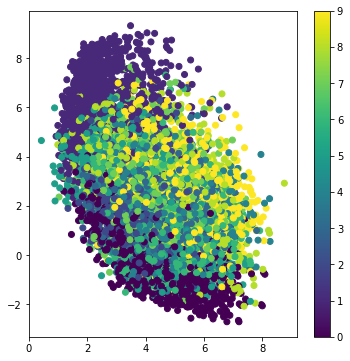

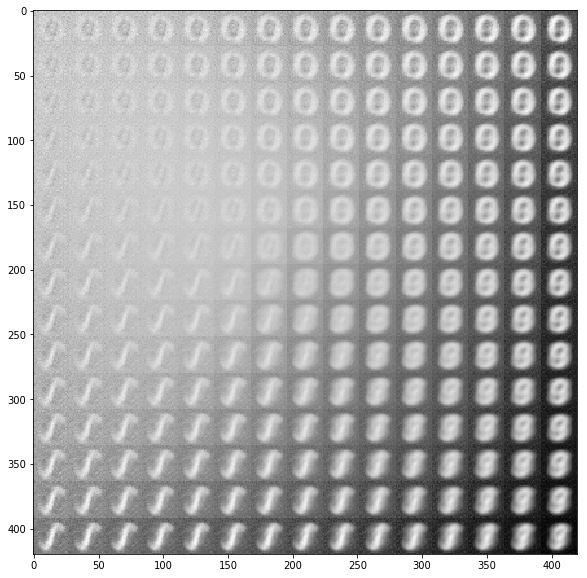

In [21]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

batch_size = 1024
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 1
epsilon_std = 1.0


x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# instantiate VAE model
vae = Model(x, x_decoded_mean)

# Compute VAE loss
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()


# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

Above we use 2 code units. Similarly we can use 8, 16 units.

## Tensorflow Implementation

Below is for generating images by varying each code unit from -3 to 3.

In [22]:
import itertools
import matplotlib as mpl
import numpy as np
import os
import tensorflow as tf
import tensorflow.contrib.slim as slim
import time
import seaborn as sns

from matplotlib import pyplot as plt
from imageio import imwrite
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets

sns.set_style('whitegrid')

distributions = tf.distributions

flags = tf.app.flags
flags.DEFINE_string('data_dir', '/tmp/dat/', 'Directory for data')
flags.DEFINE_string('logdir', '/tmp/log/', 'Directory for logs')

# For making plots:
# flags.DEFINE_integer('latent_dim', 2, 'Latent dimensionality of model')
# flags.DEFINE_integer('batch_size', 64, 'Minibatch size')
# flags.DEFINE_integer('n_samples', 10, 'Number of samples to save')
# flags.DEFINE_integer('print_every', 10, 'Print every n iterations')
# flags.DEFINE_integer('hidden_size', 200, 'Hidden size for neural networks')
# flags.DEFINE_integer('n_iterations', 1000, 'number of iterations')

# For bigger model:
flags.DEFINE_integer('latent_dim', 100, 'Latent dimensionality of model')
flags.DEFINE_integer('batch_size', 64, 'Minibatch size')
flags.DEFINE_integer('n_samples', 1, 'Number of samples to save')
flags.DEFINE_integer('print_every', 1000, 'Print every n iterations')
flags.DEFINE_integer('hidden_size', 200, 'Hidden size for neural networks')
flags.DEFINE_integer('n_iterations', 100000, 'number of iterations')

FLAGS = flags.FLAGS


def inference_network(x, latent_dim, hidden_size):
  """Construct an inference network parametrizing a Gaussian.
  Args:
    x: A batch of MNIST digits.
    latent_dim: The latent dimensionality.
    hidden_size: The size of the neural net hidden layers.
  Returns:
    mu: Mean parameters for the variational family Normal
    sigma: Standard deviation parameters for the variational family Normal
  """
  with slim.arg_scope([slim.fully_connected], activation_fn=tf.nn.relu):
    net = slim.flatten(x)
    net = slim.fully_connected(net, hidden_size)
    net = slim.fully_connected(net, hidden_size)
    gaussian_params = slim.fully_connected(
        net, latent_dim * 2, activation_fn=None)
  # The mean parameter is unconstrained
  mu = gaussian_params[:, :latent_dim]
  # The standard deviation must be positive. Parametrize with a softplus
  sigma = tf.nn.softplus(gaussian_params[:, latent_dim:])
  return mu, sigma


def generative_network(z, hidden_size):
  """Build a generative network parametrizing the likelihood of the data
  Args:
    z: Samples of latent variables
    hidden_size: Size of the hidden state of the neural net
  Returns:
    bernoulli_logits: logits for the Bernoulli likelihood of the data
  """
  with slim.arg_scope([slim.fully_connected], activation_fn=tf.nn.relu):
    net = slim.fully_connected(z, hidden_size)
    net = slim.fully_connected(net, hidden_size)
    bernoulli_logits = slim.fully_connected(net, 784, activation_fn=None)
    bernoulli_logits = tf.reshape(bernoulli_logits, [-1, 28, 28, 1])
  return bernoulli_logits


def train():
  # Train a Variational Autoencoder on MNIST

  # Input placeholders
  with tf.name_scope('data'):
    x = tf.placeholder(tf.float32, [None, 28, 28, 1])
    tf.summary.image('data', x)

  with tf.variable_scope('variational'):
    q_mu, q_sigma = inference_network(x=x,
                                      latent_dim=FLAGS.latent_dim,
                                      hidden_size=FLAGS.hidden_size)
    # The variational distribution is a Normal with mean and standard
    # deviation given by the inference network
    q_z = distributions.Normal(loc=q_mu, scale=q_sigma)
    assert q_z.reparameterization_type == distributions.FULLY_REPARAMETERIZED

  with tf.variable_scope('model'):
    # The likelihood is Bernoulli-distributed with logits given by the
    # generative network
    p_x_given_z_logits = generative_network(z=q_z.sample(),
                                            hidden_size=FLAGS.hidden_size)
    p_x_given_z = distributions.Bernoulli(logits=p_x_given_z_logits)
    posterior_predictive_samples = p_x_given_z.sample()
    tf.summary.image('posterior_predictive',
                     tf.cast(posterior_predictive_samples, tf.float32))

  # Take samples from the prior
  with tf.variable_scope('model', reuse=True):
    p_z = distributions.Normal(loc=np.zeros(FLAGS.latent_dim, dtype=np.float32),
                               scale=np.ones(FLAGS.latent_dim, dtype=np.float32))
    p_z_sample = p_z.sample(FLAGS.n_samples)
    p_x_given_z_logits = generative_network(z=p_z_sample,
                                            hidden_size=FLAGS.hidden_size)
    prior_predictive = distributions.Bernoulli(logits=p_x_given_z_logits)
    prior_predictive_samples = prior_predictive.sample()
    tf.summary.image('prior_predictive',
                     tf.cast(prior_predictive_samples, tf.float32))

  # Take samples from the prior with a placeholder
  with tf.variable_scope('model', reuse=True):
    z_input = tf.placeholder(tf.float32, [None, FLAGS.latent_dim])
    p_x_given_z_logits = generative_network(z=z_input,
                                            hidden_size=FLAGS.hidden_size)
    prior_predictive_inp = distributions.Bernoulli(logits=p_x_given_z_logits)
    prior_predictive_inp_sample = prior_predictive_inp.sample()

  # Build the evidence lower bound (ELBO) or the negative loss
  kl = tf.reduce_sum(distributions.kl_divergence(q_z, p_z), 1)
  expected_log_likelihood = tf.reduce_sum(p_x_given_z.log_prob(x),
                                          [1, 2, 3])

  elbo = tf.reduce_sum(expected_log_likelihood - kl, 0)

  optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001)

  train_op = optimizer.minimize(-elbo)

  # Merge all the summaries
  summary_op = tf.summary.merge_all()

  init_op = tf.global_variables_initializer()

  # Run training
  sess = tf.InteractiveSession()
  sess.run(init_op)

  mnist = read_data_sets(FLAGS.data_dir, one_hot=True)

  print('Saving TensorBoard summaries and images to: %s' % FLAGS.logdir)
  train_writer = tf.summary.FileWriter(FLAGS.logdir, sess.graph)

  # Get fixed MNIST digits for plotting posterior means during training
  np_x_fixed, np_y = mnist.test.next_batch(5000)
  np_x_fixed = np_x_fixed.reshape(5000, 28, 28, 1)
  np_x_fixed = (np_x_fixed > 0.5).astype(np.float32)

  t0 = time.time()
  for i in range(FLAGS.n_iterations):
    # Re-binarize the data at every batch; this improves results
    np_x, _ = mnist.train.next_batch(FLAGS.batch_size)
    np_x = np_x.reshape(FLAGS.batch_size, 28, 28, 1)
    np_x = (np_x > 0.5).astype(np.float32)
    sess.run(train_op, {x: np_x})

    # Print progress and save samples every so often
    if i % FLAGS.print_every == 0:
      np_elbo, summary_str = sess.run([elbo, summary_op], {x: np_x})
      train_writer.add_summary(summary_str, i)
      print('Iteration: {0:d} ELBO: {1:.3f} s/iter: {2:.3e}'.format(
          i,
          np_elbo / FLAGS.batch_size,
          (time.time() - t0) / FLAGS.print_every))
      t0 = time.time()

      # Save samples
      np_posterior_samples, np_prior_samples = sess.run(
          [posterior_predictive_samples, prior_predictive_samples], {x: np_x})
      for k in range(FLAGS.n_samples):
        f_name = os.path.join(
            FLAGS.logdir, 'iter_%d_posterior_predictive_%d_data.jpg' % (i, k))
        imwrite(f_name, np_x[k, :, :, 0])
        f_name = os.path.join(
            FLAGS.logdir, 'iter_%d_posterior_predictive_%d_sample.jpg' % (i, k))
        imwrite(f_name, np_posterior_samples[k, :, :, 0])
        f_name = os.path.join(
            FLAGS.logdir, 'iter_%d_prior_predictive_%d.jpg' % (i, k))
        imwrite(f_name, np_prior_samples[k, :, :, 0])

      # Plot the posterior predictive space
      if FLAGS.latent_dim == 2:
        np_q_mu = sess.run(q_mu, {x: np_x_fixed})
        cmap = mpl.colors.ListedColormap(sns.color_palette("husl"))
        f, ax = plt.subplots(1, figsize=(6 * 1.1618, 6))
        im = ax.scatter(np_q_mu[:, 0], np_q_mu[:, 1], c=np.argmax(np_y, 1), cmap=cmap,
                        alpha=0.7)
        ax.set_xlabel('First dimension of sampled latent variable $z_1$')
        ax.set_ylabel('Second dimension of sampled latent variable mean $z_2$')
        ax.set_xlim([-10., 10.])
        ax.set_ylim([-10., 10.])
        f.colorbar(im, ax=ax, label='Digit class')
        plt.tight_layout()
        plt.savefig(os.path.join(FLAGS.logdir,
                                 'posterior_predictive_map_frame_%d.png' % i))
        plt.close()

        nx = ny = 20
        x_values = np.linspace(-3, 3, nx)
        y_values = np.linspace(-3, 3, ny)
        canvas = np.empty((28 * ny, 28 * nx))
        for ii, yi in enumerate(x_values):
          for j, xi in enumerate(y_values):
            np_z = np.array([[xi, yi]])
            x_mean = sess.run(prior_predictive_inp_sample, {z_input: np_z})
            canvas[(nx - ii - 1) * 28:(nx - ii) * 28, j *
                   28:(j + 1) * 28] = x_mean[0].reshape(28, 28)
        imwrite(os.path.join(FLAGS.logdir,
                            'prior_predictive_map_frame_%d.png' % i), canvas)
        # plt.figure(figsize=(8, 10))
        # Xi, Yi = np.meshgrid(x_values, y_values)
        # plt.imshow(canvas, origin="upper")
        # plt.tight_layout()
        # plt.savefig()

  # Make the gifs
  if FLAGS.latent_dim == 2:
    os.system(
        'convert -delay 15 -loop 0 {0}/posterior_predictive_map_frame*png {0}/posterior_predictive.gif'
        .format(FLAGS.logdir))
    os.system(
        'convert -delay 15 -loop 0 {0}/prior_predictive_map_frame*png {0}/prior_predictive.gif'
        .format(FLAGS.logdir))


def main(_):
  if tf.gfile.Exists(FLAGS.logdir):
    tf.gfile.DeleteRecursively(FLAGS.logdir)
  tf.gfile.MakeDirs(FLAGS.logdir)
  train()


if __name__ == '__main__':
  tf.app.run()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/dat/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/dat/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/dat/t10k-images-idx3-ubyte.gz
Extracting /tmp/dat/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Saving TensorBoard summaries and images to: /tmp/log/
Iteration: 0 ELBO: -526.988 s/iter: 9.391e-03


Iteration: 1000 ELBO: -127.839 s/iter: 7.822e-02


Iteration: 2000 ELBO: -110.702 s/iter: 7.616e-02


Iteration: 3000 ELBO: -98.942 s/iter: 6.632e-02


Iteration: 4000 ELBO: -101.240 s/iter: 6.655e-02


Iteration: 5000 ELBO: -95.281 s/iter: 6.618e-02


Iteration: 6000 ELBO: -92.805 s/iter: 6.640e-02


Iteration: 7000 ELBO: -94.490 s/iter: 6.609e-02


Iteration: 8000 ELBO: -90.098 s/iter: 6.628e-02


Iteration: 9000 ELBO: -96.618 s/iter: 6.654e-02


Iteration: 10000 ELBO: -87.360 s/iter: 6.655e-02


Iteration: 11000 ELBO: -86.766 s/iter: 6.638e-02


Iteration: 12000 ELBO: -88.529 s/iter: 6.658e-02


Iteration: 13000 ELBO: -86.691 s/iter: 6.623e-02


Iteration: 14000 ELBO: -93.170 s/iter: 6.675e-02


Iteration: 15000 ELBO: -85.147 s/iter: 6.627e-02


Iteration: 16000 ELBO: -84.726 s/iter: 6.589e-02


Iteration: 17000 ELBO: -84.498 s/iter: 8.031e-02


Iteration: 18000 ELBO: -81.530 s/iter: 6.746e-02


Iteration: 19000 ELBO: -88.833 s/iter: 6.867e-02


Iteration: 20000 ELBO: -89.568 s/iter: 6.751e-02


Iteration: 21000 ELBO: -86.258 s/iter: 6.651e-02


Iteration: 22000 ELBO: -88.101 s/iter: 6.630e-02


Iteration: 23000 ELBO: -83.870 s/iter: 6.667e-02


Iteration: 24000 ELBO: -86.432 s/iter: 7.141e-02


Iteration: 25000 ELBO: -88.686 s/iter: 8.120e-02


Iteration: 26000 ELBO: -88.132 s/iter: 6.626e-02


Iteration: 27000 ELBO: -85.616 s/iter: 7.105e-02


Iteration: 28000 ELBO: -80.159 s/iter: 8.137e-02


Iteration: 29000 ELBO: -86.583 s/iter: 8.480e-02


Iteration: 30000 ELBO: -84.704 s/iter: 8.708e-02


Iteration: 31000 ELBO: -82.341 s/iter: 8.173e-02


Iteration: 32000 ELBO: -83.574 s/iter: 7.357e-02


Iteration: 33000 ELBO: -85.366 s/iter: 8.059e-02


Iteration: 34000 ELBO: -85.360 s/iter: 8.214e-02


Iteration: 35000 ELBO: -89.481 s/iter: 7.848e-02


Iteration: 36000 ELBO: -81.996 s/iter: 8.168e-02


Iteration: 37000 ELBO: -79.084 s/iter: 6.940e-02


Iteration: 38000 ELBO: -79.069 s/iter: 7.040e-02


Iteration: 39000 ELBO: -85.777 s/iter: 7.660e-02


Iteration: 40000 ELBO: -89.223 s/iter: 6.658e-02


Iteration: 41000 ELBO: -79.647 s/iter: 6.690e-02


Iteration: 42000 ELBO: -87.099 s/iter: 6.736e-02


Iteration: 43000 ELBO: -86.030 s/iter: 6.720e-02


Iteration: 44000 ELBO: -87.756 s/iter: 7.708e-02


Iteration: 45000 ELBO: -85.562 s/iter: 7.212e-02


Iteration: 46000 ELBO: -87.863 s/iter: 7.699e-02


Iteration: 47000 ELBO: -90.494 s/iter: 7.666e-02


Iteration: 48000 ELBO: -87.964 s/iter: 8.250e-02


Iteration: 49000 ELBO: -88.773 s/iter: 8.534e-02


Iteration: 50000 ELBO: -85.915 s/iter: 8.905e-02


Iteration: 51000 ELBO: -87.507 s/iter: 8.560e-02


Iteration: 52000 ELBO: -85.916 s/iter: 8.857e-02


Iteration: 53000 ELBO: -89.530 s/iter: 9.031e-02


Iteration: 54000 ELBO: -86.161 s/iter: 9.130e-02


Iteration: 55000 ELBO: -88.480 s/iter: 9.003e-02


Iteration: 56000 ELBO: -83.867 s/iter: 8.570e-02


Iteration: 57000 ELBO: -81.892 s/iter: 8.609e-02


Iteration: 58000 ELBO: -85.010 s/iter: 8.695e-02


Iteration: 59000 ELBO: -85.479 s/iter: 8.835e-02


Iteration: 60000 ELBO: -80.775 s/iter: 8.621e-02


Iteration: 61000 ELBO: -80.588 s/iter: 8.628e-02


Iteration: 62000 ELBO: -90.529 s/iter: 8.585e-02


Iteration: 63000 ELBO: -85.706 s/iter: 8.610e-02


Iteration: 64000 ELBO: -86.071 s/iter: 8.629e-02


Iteration: 65000 ELBO: -92.919 s/iter: 8.534e-02


Iteration: 66000 ELBO: -78.873 s/iter: 8.890e-02


Iteration: 67000 ELBO: -82.137 s/iter: 8.570e-02


Iteration: 68000 ELBO: -85.709 s/iter: 8.612e-02


Iteration: 69000 ELBO: -80.762 s/iter: 8.605e-02


Iteration: 70000 ELBO: -83.584 s/iter: 8.639e-02


Iteration: 71000 ELBO: -87.275 s/iter: 8.595e-02


Iteration: 72000 ELBO: -87.108 s/iter: 8.608e-02


KeyboardInterrupt: 